In [ ]:
!pip install accelerate datasets evaluate tensorboard

In [ ]:
!pip install transformers==4.45.2 sentence-transformers==3.1.1

In [ ]:
!pip install bitsandbytes

In [ ]:
!pip install emoji

In [5]:
import pandas as pd
import numpy as np
import re
import emoji
import os

In [25]:
import pandas as pd
import numpy as np
import evaluate
import transformers
import torch

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import (
    AutoTokenizer,
    MistralForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from transformers import EarlyStoppingCallback
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [7]:
data_train = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/Model for benchmark/data/train.csv')

In [8]:
data_train = data_train.drop(columns=['Unnamed: 0'])

In [9]:
data_train['Оценка'].value_counts()

,count
Оценка,
2,379
4,379
5,379
6,379
7,379
0,379
1,379
3,378
8,378


In [10]:
data_test = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/data_test(sp).csv')

In [11]:
data_test = data_test.drop(columns=['Unnamed: 0'])

In [12]:
X = data_train['message.text']
y = data_train['Оценка']
X_test = data_test['message.text']
y_test = data_test['Оценка']

In [13]:
y = y.apply(lambda x: x if x > 1 else 1)
y = y-1

In [14]:
y_test = y_test.apply(lambda x: x if x > 1 else 1)
y_test = y_test-1

# Предобработка

In [16]:
def convert_emojis_to_words(text):

    # Convert emojis to words
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove the : from the words and replace _ with space
    text = text.replace(":", " ").replace("_", " ")

    return text

In [17]:
symbols_pattern = re.compile(pattern = "["
    "@_!#$%^&*()<>?/\|}{~√•—"
                       "]+", flags = re.UNICODE) #спецсимволы
# двойные пробелы
space_pattern = re.compile('\s+')
#exclude = set(string.punctuation) # удаление пунктуации
def clear_text(text):
    """ Функция удаления спецсимволов"""
    # удаление спецсимволов и emoji
    pre = symbols_pattern.sub(r'',text)
    pre = re.sub(r'http\S+', '', pre)
    pre = convert_emojis_to_words(pre)


    return space_pattern.sub(' ', pre)

In [18]:
def preprocess_text(text):
    """ Финальная функция для обработки """
    # srip + lower + punctuation
    sentence = (
        ''.join([x for x in str(text).strip().lower()])
    )

    return clear_text(sentence)

In [19]:
X = X.apply(preprocess_text)

In [20]:
X_test = X_test.apply(preprocess_text)

In [21]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
The token `for skillfactory` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `f

In [22]:
quantization_config = BitsAndBytesConfig(load_in_8bit=True)

In [26]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
model = MistralForSequenceClassification.from_pretrained("mistralai/Mistral-7B-v0.1", quantization_config=quantization_config, num_labels = 8)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of MistralForSequenceClassification were not initialized from the model checkpoint at mistralai/Mistral-7B-v0.1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [28]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32001, 4096)

In [29]:
model.config.pad_token_id = tokenizer.pad_token_id

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state = 42, stratify =y)

In [31]:
class CustomDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        super().__init__()
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        text = self.X.iloc[idx]
        #text = self.text.iloc[idx]
        label = self.y.iloc[idx]
        output = self.tokenizer(
            text,
            max_length=512,
            padding='max_length',
            truncation=True
            #return_tensors="pt"
        )

        #one_hot_labels = torch.nn.functional.one_hot(label - 1, num_classes=10)
        output["label"]= torch.tensor(label)
        return output

In [32]:
tokenized_train = CustomDataset(X_train, y_train, tokenizer)
tokenized_val = CustomDataset(X_val, y_val, tokenizer)

In [33]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [34]:
train_dataloader = DataLoader(
    CustomDataset(
        X = X_train,
        y = y_train,
        tokenizer = tokenizer),
    collate_fn=data_collator,
    batch_size=32,
    shuffle=True
)

In [35]:
next(iter(train_dataloader))

{'input_ids': tensor([[32000, 32000, 32000,  ..., 13258,   703, 28723],
        [32000, 32000, 32000,  ...,  3647, 28773, 28723],
        [32000, 32000, 32000,  ...,  1788, 28778, 12988],
        ...,
        [32000, 32000, 32000,  ..., 28788,  3647, 28773],
        [32000, 32000, 32000,  ..., 18878,  8848, 28723],
        [32000, 32000, 32000,  ..., 28788,  3647, 28773]]), 'attention_mask': tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'labels': tensor([0, 0, 5, 6, 5, 7, 6, 0, 5, 1, 4, 6, 0, 7, 0, 6, 3, 7, 4, 0, 6, 7, 0, 2,
        3, 6, 3, 0, 6, 5, 4, 5])}

In [36]:
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

In [37]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.from_numpy(logits)
    labels = torch.from_numpy(labels)
    if torch.isnan(logits).any() or torch.isinf(logits).any():
        print("Warning: NaN or inf values detected in logits.")
    predictions = np.argmax(logits, axis=-1)
    global f1_metric, accuracy_metric
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')['f1']
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']
    return {"accuracy": accuracy,'f1_score': f1}


In [38]:
training_args = TrainingArguments(
    output_dir="//content/drive/MyDrive/finetuning_mistral_LORA4/",
    per_device_train_batch_size= 4,
    per_device_eval_batch_size = 4,
    eval_accumulation_steps=50,
    learning_rate=1e-4,
	  num_train_epochs=5,
    gradient_accumulation_steps=2,
    logging_strategy="steps",
    logging_steps=100,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_total_limit=2,
    optim="adamw_bnb_8bit",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy")
    #report_to="tensorb")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
from peft import LoraConfig, get_peft_model

In [40]:
# **PEFT configuration (LoRA)**
peft_config = LoraConfig(
    r=16,  # Rank of the LoRA update matrices
    lora_alpha=16,  # Scaling factor for the LoRA update matrices
    lora_dropout=0.2,  # Dropout probability for the LoRA update matrices
    bias="none",
    modules_to_save=["decode_head"],
    task_type="SEQ_CLS" ) # Task type for sequence classification

# **Wrap the model with PEFT**
lora_model = get_peft_model(model, peft_config)
lora_model.print_trainable_parameters()

trainable params: 6,848,512 || all params: 7,117,545,472 || trainable%: 0.0962


In [41]:
trainer = Trainer(
    lora_model,
    args=training_args,
    train_dataset=CustomDataset(X_train, y_train, tokenizer=tokenizer),  # Use the Dataset object
    eval_dataset=CustomDataset(X_val, y_val, tokenizer=tokenizer),  # Use the Dataset object
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(3, 0.0)]
)

In [42]:
torch.cuda.empty_cache()

In [43]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: busuevatatana472 (busuevatatana472-mfti) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1 Score
100,2.379400,1.647461,0.507331,0.514350
200,1.470900,1.210938,0.680352,0.667718
300,1.241700,1.161133,0.671554,0.664208
400,1.013000,0.935547,0.727273,0.731680
500,0.698200,1.015625,0.750733,0.740927
600,0.612300,0.806152,0.762463,0.757408
700,0.545600,0.883789,0.794721,0.804209
800,0.556300,0.832520,0.797654,0.793810
900,0.398800,0.876465,0.809384,0.809738
1000,0.370000,1.052734,0.785924,0.774402


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


TrainOutput(global_step=1800, training_loss=0.5940538708368938, metrics={'train_runtime': 3728.8856, 'train_samples_per_second': 4.114, 'train_steps_per_second': 0.514, 'total_flos': 3.090590484922368e+17, 'train_loss': 0.5940538708368938, 'epoch': 4.69361147327249})

In [48]:
test = trainer.predict(CustomDataset(X_test, y_test, tokenizer=tokenizer))

In [45]:
model_id = "//content/drive/MyDrive/finetuning_mistral_LORA4/mistral_with_lora"
lora_model.save_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


In [46]:
trainer.save_model()

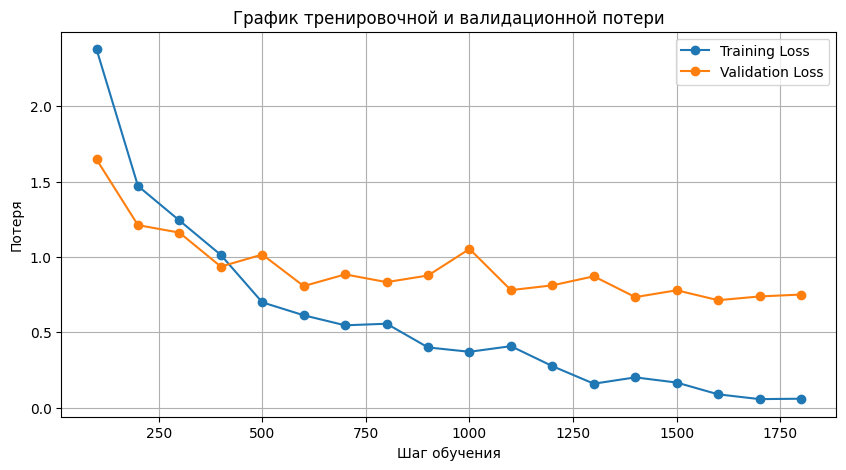

<Figure size 640x480 with 0 Axes>

In [47]:
import matplotlib.pyplot as plt

# Извлекаем историю логирования
log_history = trainer.state.log_history

# Списки для тренировочной и валидационной потерь и соответствующих шагов
train_steps, train_losses = [], []
eval_steps, eval_losses = [], []

for entry in log_history:
    # Тренировочная потеря
    if "loss" in entry:
        # Используем шаг обучения, если он есть, иначе порядковый номер
        train_steps.append(entry.get("step", len(train_steps) + 1))
        train_losses.append(entry["loss"])
    # Валидационная потеря
    if "eval_loss" in entry:
        eval_steps.append(entry.get("step", len(eval_steps) + 1))
        eval_losses.append(entry["eval_loss"])

# Построение графика
plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_losses, marker="o", label="Training Loss")
plt.plot(eval_steps, eval_losses, marker="o", label="Validation Loss")
plt.xlabel("Шаг обучения")
plt.ylabel("Потеря")
plt.title("График тренировочной и валидационной потери")
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('mistral_train_val.png')

In [49]:
y_pred = np.argmax(test[0],axis=1)

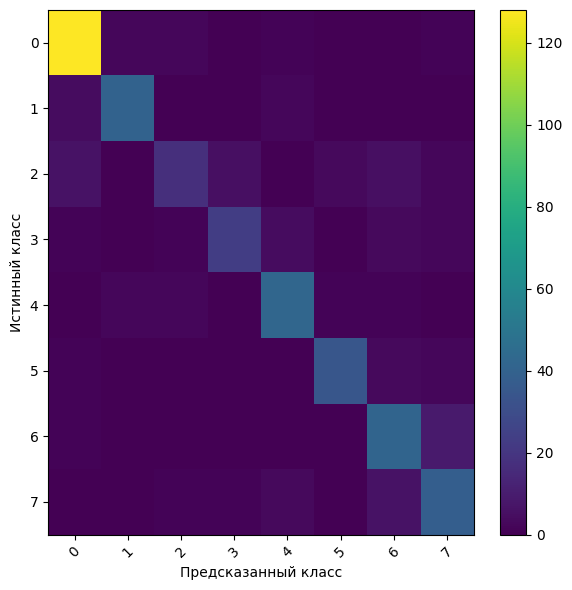

In [50]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', aspect='auto')
unique_labels = np.unique(y_test).astype(int)
ax.set_xticks(range(8))
ax.set_yticks(range(8))
ax.set_xticklabels(unique_labels, rotation=45)
ax.set_yticklabels(unique_labels)
ax.set_ylabel('Истинный класс')
ax.set_xlabel('Предсказанный класс')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# y_true, y_pred — ваши реальные и предсказанные метки, оба одномерных np.array

# Сначала получим список всех классов
classes = np.unique(y_test)

# 1) F1-score по классам
f1_per_class = f1_score(y_test, y_pred, labels=classes, average=None, zero_division=0)

# 2) «Точность по классу» как доля правильно предсказанных среди всех примеров этого класса
#    (этот показатель в мультиклассе эквивалентен recall для данного класса)
accuracy_per_class = np.array([
    np.mean(y_pred[y_test == cls] == cls)
    for cls in classes
])

# 3) Собираем всё в DataFrame
df = pd.DataFrame({
    'class': classes.astype(str),
    'accuracy': accuracy_per_class,
    'f1_score': f1_per_class
}).set_index('class')

print(df)

       accuracy  f1_score
class                    
0      0.955224  0.930909
1      0.869565  0.888889
2      0.447368  0.557377
3      0.676471  0.730159
4      0.875000  0.840000
5      0.850000  0.871795
6      0.803922  0.745455
7      0.775510  0.737864
